In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg

# Задача 3.1
Реализовать решение СЛАУ с помощью LU разложения и LU разложения по схеме частичного выбора. Решить систему небольшой размерности с возмущенной матрицей обоими методами, оценить погрешность и сравнить с теоретической оценкой. Проанализировать поведение методов с ростом числа уравнений.
Элементы мматрицы задаются формулой

$A_{i, j} = \tan^{17-j}{(i+1)} \quad \forall i, j \in [1, n] $

In [8]:
#решение по схеме частичного выбора; модификация исходной матрицы
def solveLU(A, b):
    mtr = np.copy(A)
    n = len(A)
    x = np.zeros(n)
    y = np.zeros(n)
    
    for u in range (n):
        for i in range (u+1, n):
            mtr[i][u] = mtr[i][u] / mtr[u][u]
            for j in range (u+1, n):
                mtr[i][j] = mtr[i][j] - mtr[i][u] * mtr[u][j]
                
    for i in range (n):
        y[i] = b[i] - np.sum([ mtr[i][j] * y[j] for j in range (i) ])
    for i in range (n-1, -1, -1):
        x[i] = (y[i] - np.sum([x[j] * mtr[i][j] for j in range (n-1, i-1, -1)])) / mtr[i][i]
        
    return x

In [9]:
#LU разложение и матрица перестановок
def permMtr(A):
    n = len(A)
    L = np.eye(n)
    U = np.copy(A)
    perm = np.eye(n)
    
    for u in range (n-1):
        ph = np.eye(n)
        uh = np.eye(n)
        lh = np.eye(n)
        maxEl = U[u][u].copy()
        im = u
        
        for i in range (u+1, n):
            if (abs(maxEl) < abs(U[i][u])):
                maxEl = U[i][u].copy()
                im = i
        ph[im], ph[u] = np.copy(ph[u]), np.copy(ph[im])
        U = ph @ U
        
        for i in range (u+1, n):
            h = U[i][u] / U[u][u]
            uh[i][u] = -h
            lh[i][u] = h
        U = uh @ U
        perm = ph @ perm
        L = L @ ph @ lh
        
    L = perm @ L
    
    return (L, U, perm)

In [10]:
#решение системы
def solve(L, U, perm, b):
    b = perm @ b
    n = len(L)
    y = np.zeros(n)
    x = np.zeros(n)
    
    for i in range (n):
        y[i] = b[i] - np.sum([L[i][j]*y[j] for j in range (i)])
        
    for i in range (n-1, -1, -1):
        x[i] = (y[i] - np.sum([x[j] * U[i][j] for j in range (n-1, i-1, -1)]))/U[i][i]  
    return x

In [11]:
A = np.array([[((np.tan(i+1))**(17-j)) for j in range (5)] for i in range (5)])
X = np.array([11]*5)
b = A @ X
bEps = b
bEps[0] += 1e-3
AEps = np.copy(A)
AEps[0][0] += 1e-3

x1 = solveLU(AEps, bEps)

lh, uh, ph = permMtr(AEps)
x2 = solve(lh, uh, ph, bEps)

print('x1 =', x1)
print('x2 =', x2)

x1 = [10.99999749 10.99998857 10.99999605 11.00002115 11.00000306]
x2 = [10.99999749 10.99998857 10.99999605 11.00002115 11.00000306]


In [12]:
def errX (x, X):
    return np.linalg.norm(x-X)/np.linalg.norm(x)

def errXscr (A, b):
    return np.linalg.cond(A)*(1e-3/np.linalg.norm(A, 2) + 1e-3/np.linalg.norm(b, 2))

print('error X:     ', errX(x2, X))
print('score error: ', errXscr (A, b))

error X:      1.0033553055293403e-06
score error:  136489180.35097033


In [14]:
print(np.linalg.cond(AEps))

1.2697189609729678e+20


In [15]:
errX1 = []
errX2 = []
for n in range (5, 15):
    A = np.array([ [((np.tan(i+1)**(17-j))) for j in range (n)] for i in range (n)])
    X = np.array([11]*n)
    b = A @ X
    bEps = b
    bEps[0] += 1e-3
    AEps = np.copy(A)
    AEps[0][0] += 1e-3
    
    x1 = solveLU(AEps, bEps)
    lh, uh, ph = permMtr(AEps)
    x2 = solve(lh, uh, ph, bEps)
    
    errX1.append(errX(x1, X))
    errX2.append(errX(x2, X))

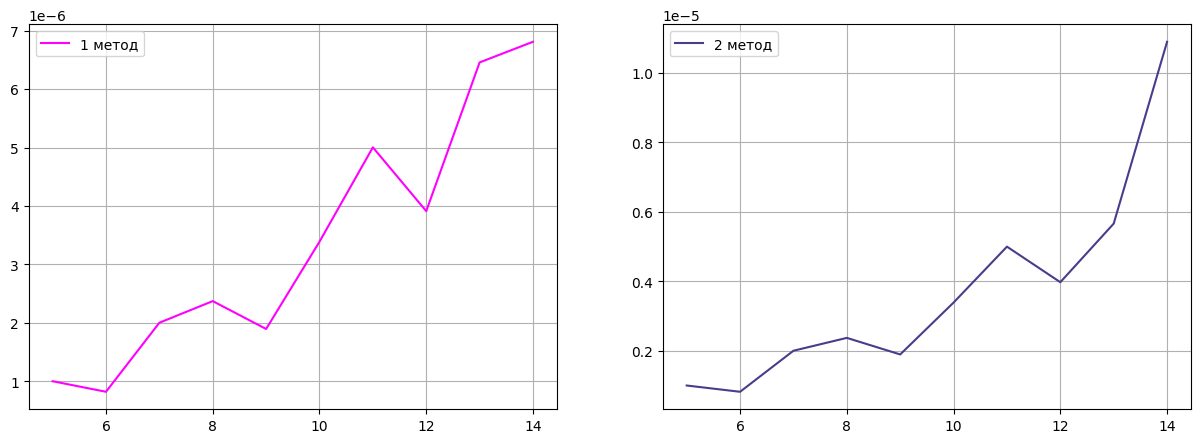

In [16]:
fix, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].plot(range(5, 15), errX1, color = 'fuchsia', label = '1 метод')
axs[1].plot(range(5, 15), errX2, color = 'darkslateblue', label = '2 метод')
axs[0].legend()
axs[0].grid()
axs[1].legend()
axs[1].grid()

# Задача 3.2
Дана система уравнений $Ax=b$  порядка $n = 52$ с разреженной матрицей . Решить систему прямым методом.

На главной диагонали и в 10-ом столбце элементы равны 15, на побочной диагонали элементы равны 2

$b_i = i^3 - \sqrt{2i}$


In [17]:
#решение по собственному методу
def SimakovMeth(main, side, col, b):
    x = np.zeros(52)
    x[42] = (main * b[26] - side * b[9]) / ((main)**(2) - (side)**(2))
    x[9] = (b[9] - side * x[42]) / main
    
    for i in range (26):
        if i != 9:
            x[51-i] = (main*b[51-i] - side*b[i] + side*col*x[9] - main*col*x[9])/((main)**(2) - (side)**(2))
            x[i] = (b[i] - col*x[9] - side*x[51-i])/main
    return x

In [18]:
#тестовый пример
main = 2
side = 1
col = 3
b = [3]*52

xT = SimakovMeth(main, side, col, b)
print(xT)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [19]:
#матрица из задачи
b = [0]*52
for i in range (0, 52):
    b[i] = i**3 - np.sqrt(2*i)

main = 15
side = 2
col = 15

x1 = SimakovMeth(main, side, col, b)
print(np.round(x1, 3))

[-1103.486 -1034.275  -967.316  -902.194  -838.451  -775.628  -713.265
  -650.9    -588.073  -109.802  -459.184  -392.2    -322.907  -250.845
  -175.551   -96.565   -13.424    74.332   167.166   265.538   369.911
   480.745   598.503   723.645   856.634   997.931  1147.997  1307.294
  1476.284  1655.427  1845.186  2046.022  2258.397  2482.772  2719.608
  2969.367  3232.512  3509.502  3800.8    4106.867  4428.166  4765.156
  1185.893  5488.06   5874.897  6279.271  6701.646  7142.482  7602.241
  8081.384  8580.372  9099.66 ]


# Задача 3.3
Дана система уравнений $Ax=b$  порядка $m = 26$. Решить методом минимальных невязок.

$x_i = 49$
$\beta = 572$

$A_{i, j} = \frac{\cos{(i+j)}}{0.1\beta} + 0.1\beta e^{-(i-j)^2} \quad \forall i, j \in [1, m]$

In [20]:
m = 26
beta = 572
eps = 10**(-12)

#метод минимальных невязок
def minResMeth(A, b, eps):
    it = 0
    x = np.zeros(m)
    y = np.zeros(m)
    y = A@x - b
    while (linalg.norm(A@x - b, ord = 2)/linalg.norm(b, ord = 2)) >= eps:
        t = np.sum((A@y)*y)/np.sum((A@y)*(A@y))
        x -= (t*y)
        y = A@x - b
        it += 1
    return x, it

In [21]:
A = np.array([[np.math.cos(i + j)/(0.1*beta) + 0.1*beta*np.math.exp(-(i-j)**2) for j in range (m)] for i in range (m)])
xh = np.array([49]*26)
b = A@xh
x, it = minResMeth(A, b, eps)

print('x = ', x)
print('')
print('it =', it)

x =  [49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49.]

it = 59
